# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

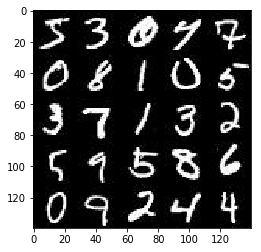

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

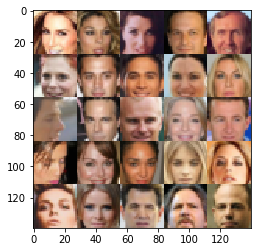

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

C:\Users\F.WAN\AppData\Local\Continuum\miniconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


TensorFlow Version: 1.8.0
Default GPU Device: /device:GPU:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    images_ph = tf.placeholder(tf.float32, shape=[None, image_width, image_height, \
                        image_channels], name='images_ph')
    z_input = tf.placeholder(tf.float32, shape=[None, z_dim], name='input_z')
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')

    return images_ph, z_input, learning_rate

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the generator, tensor logits of the generator).

In [6]:
def discriminator(images, reuse=False, alpha=0.01):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    with tf.variable_scope('discriminator', reuse=reuse):
        
#         conv = tf.layers.conv2d(images, 8, 1, 1, 'SAME')
        conv = tf.layers.conv2d(images, 16, 3, 2, 'SAME', kernel_regularizer=tf.contrib.layers.l2_regularizer(scale=0.01),kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d())
        conv = tf.layers.batch_normalization(conv, training=True)
        conv = tf.nn.leaky_relu(alpha=0.2, features=conv)

        conv = tf.layers.conv2d(conv, 32, 5, 2, 'SAME', kernel_regularizer=tf.contrib.layers.l2_regularizer(scale=0.01),kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d())
        conv = tf.layers.batch_normalization(conv, training=True)
        conv = tf.nn.leaky_relu(alpha=0.2, features=conv)
        
        conv = tf.layers.conv2d(conv, 64, 3, 2, 'SAME', kernel_regularizer=tf.contrib.layers.l2_regularizer(scale=0.01),kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d())
        conv = tf.layers.batch_normalization(conv, training=True)
        conv = tf.nn.leaky_relu(alpha=0.2, features=conv)
        
        conv = tf.layers.conv2d(conv, 128, 3, 2, 'SAME', kernel_regularizer=tf.contrib.layers.l2_regularizer(scale=0.01),kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d())
        conv = tf.layers.batch_normalization(conv, training=True)
        conv = tf.nn.leaky_relu(alpha=0.2, features=conv)
        
        flat   = tf.reshape(conv, (-1, 4*4*128))
        logits = tf.layers.dense(flat, 1)
        logits = tf.layers.dropout(inputs=logits, rate=0.5)
        output = tf.sigmoid(logits)
    return output, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True, alpha=0.2):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    with tf.variable_scope('generator', reuse=not is_train):
            gen_layer = tf.layers.dense(inputs=z, units=7*7*512, use_bias=False)
            
#             gen_layer = tf.layers.conv2d_transpose(gen_layer, 512, 5, 2,'SAME', use_bias=False)
            gen_layer = tf.layers.batch_normalization(gen_layer, training=is_train)
            gen_layer = tf.reshape(gen_layer, (-1, 7, 7, 512))
            gen_layer = tf.layers.batch_normalization(gen_layer, training=is_train)
            gen_layer = tf.nn.leaky_relu(alpha=0.2, features=gen_layer)
            
            gen_layer = tf.layers.conv2d_transpose(gen_layer, 256, 5, 2,'SAME', use_bias=False)
            gen_layer = tf.layers.batch_normalization(gen_layer, training=is_train)
            gen_layer = tf.nn.leaky_relu(alpha=0.2, features=gen_layer)  
            
            gen_layer = tf.layers.conv2d_transpose(gen_layer, 128, 5, 2,'SAME', use_bias=False)
            gen_layer = tf.layers.batch_normalization(gen_layer, training=is_train)
            gen_layer = tf.nn.leaky_relu(alpha=0.2, features=gen_layer)           


            gen_layer = tf.layers.conv2d_transpose(gen_layer, 36, 5, 1,'SAME', use_bias=False)
            gen_layer = tf.layers.batch_normalization(gen_layer, training=is_train)
            gen_layer = tf.nn.leaky_relu(alpha=0.2, features=gen_layer)

            gen_layer = tf.layers.conv2d_transpose(gen_layer, out_channel_dim, 5, 1,'SAME', use_bias=False)
            out = tf.tanh(gen_layer)

    return out



"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim, alpha=0.9):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    # Calculate the Losses for it real, fake & generated models
    # Label smoothing for discriminator is according to https://github.com/soumith/ganhacks
    d_loss_real = tf.reduce_mean( tf.nn.sigmoid_cross_entropy_with_logits(
        logits=d_logits_real, labels=tf.random_uniform(tf.shape(d_model_real), minval=0.7, maxval=1.2)))
    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
        logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))    
    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
        logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))
    
    # The Discriminator Loss is the amount of it fake img loss + it real img loss
    d_loss = d_loss_real + d_loss_fake
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    all_vars = tf.trainable_variables()
    d_vars = [v for v in all_vars if v.name.startswith('discriminator')]
    g_vars = [v for v in all_vars if v.name.startswith('generator')]
    
    # Optimizer
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1).minimize(g_loss, var_list=g_vars)
        
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """

    
    input_real, input_z, lr = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)

    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])

    d_opt, g_opt = model_opt(d_loss, g_loss, lr, beta1)
    
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            steps = 0
            for batch_images in get_batches(batch_size):
                steps +=1
                batch_images = batch_images * 2
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr: learning_rate})                
                _ = sess.run(g_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr: learning_rate})
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr: learning_rate})                
                _ = sess.run(g_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr: learning_rate})
                if steps % 10 == 0:
                    train_loss_d = d_loss.eval({input_real: batch_images, input_z: batch_z})
                    train_loss_g = g_loss.eval({input_z: batch_z})
                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Batch {}...".format(steps),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))

                if steps % 100 == 0:
                    show_generator_output(sess, show_n_images, input_z, data_shape[3], data_image_mode)
            show_generator_output(sess, 25, input_z, data_shape[3], data_image_mode)


### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Batch 10... Discriminator Loss: 0.5034... Generator Loss: 4.2364
Epoch 1/2... Batch 20... Discriminator Loss: 1.3926... Generator Loss: 0.9282
Epoch 1/2... Batch 30... Discriminator Loss: 1.8212... Generator Loss: 0.4537
Epoch 1/2... Batch 40... Discriminator Loss: 1.6336... Generator Loss: 0.5365
Epoch 1/2... Batch 50... Discriminator Loss: 1.6465... Generator Loss: 0.5488
Epoch 1/2... Batch 60... Discriminator Loss: 1.5423... Generator Loss: 0.5342
Epoch 1/2... Batch 70... Discriminator Loss: 1.5424... Generator Loss: 0.5994
Epoch 1/2... Batch 80... Discriminator Loss: 1.4281... Generator Loss: 0.6420
Epoch 1/2... Batch 90... Discriminator Loss: 1.6287... Generator Loss: 0.5974
Epoch 1/2... Batch 100... Discriminator Loss: 1.2753... Generator Loss: 0.7591


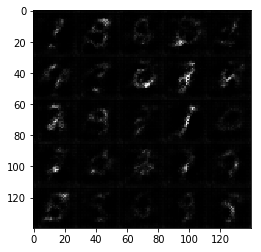

Epoch 1/2... Batch 110... Discriminator Loss: 1.2589... Generator Loss: 0.8506
Epoch 1/2... Batch 120... Discriminator Loss: 1.5769... Generator Loss: 0.6266
Epoch 1/2... Batch 130... Discriminator Loss: 1.3554... Generator Loss: 0.6929
Epoch 1/2... Batch 140... Discriminator Loss: 1.5098... Generator Loss: 0.6259
Epoch 1/2... Batch 150... Discriminator Loss: 1.5837... Generator Loss: 0.6932
Epoch 1/2... Batch 160... Discriminator Loss: 1.4900... Generator Loss: 0.6539
Epoch 1/2... Batch 170... Discriminator Loss: 1.4296... Generator Loss: 0.7441
Epoch 1/2... Batch 180... Discriminator Loss: 1.4144... Generator Loss: 0.6423
Epoch 1/2... Batch 190... Discriminator Loss: 1.2863... Generator Loss: 0.8295
Epoch 1/2... Batch 200... Discriminator Loss: 1.4692... Generator Loss: 0.9028


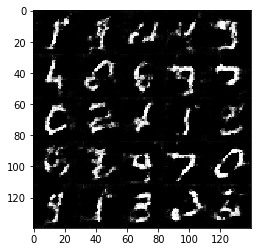

Epoch 1/2... Batch 210... Discriminator Loss: 1.4275... Generator Loss: 0.7270
Epoch 1/2... Batch 220... Discriminator Loss: 1.4233... Generator Loss: 0.8296
Epoch 1/2... Batch 230... Discriminator Loss: 1.3939... Generator Loss: 0.6809
Epoch 1/2... Batch 240... Discriminator Loss: 1.2993... Generator Loss: 0.7788
Epoch 1/2... Batch 250... Discriminator Loss: 1.4397... Generator Loss: 0.6139
Epoch 1/2... Batch 260... Discriminator Loss: 1.4485... Generator Loss: 0.5854
Epoch 1/2... Batch 270... Discriminator Loss: 1.2111... Generator Loss: 1.0306
Epoch 1/2... Batch 280... Discriminator Loss: 1.3833... Generator Loss: 0.7035
Epoch 1/2... Batch 290... Discriminator Loss: 1.4073... Generator Loss: 0.7245
Epoch 1/2... Batch 300... Discriminator Loss: 1.4130... Generator Loss: 0.6331


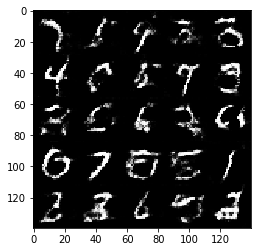

Epoch 1/2... Batch 310... Discriminator Loss: 1.4661... Generator Loss: 0.6103
Epoch 1/2... Batch 320... Discriminator Loss: 1.3146... Generator Loss: 0.7184
Epoch 1/2... Batch 330... Discriminator Loss: 1.4166... Generator Loss: 0.7916
Epoch 1/2... Batch 340... Discriminator Loss: 1.3966... Generator Loss: 0.7766
Epoch 1/2... Batch 350... Discriminator Loss: 1.4487... Generator Loss: 0.6287
Epoch 1/2... Batch 360... Discriminator Loss: 1.4103... Generator Loss: 0.7988
Epoch 1/2... Batch 370... Discriminator Loss: 1.3727... Generator Loss: 0.8417
Epoch 1/2... Batch 380... Discriminator Loss: 1.3643... Generator Loss: 0.6920
Epoch 1/2... Batch 390... Discriminator Loss: 1.2970... Generator Loss: 0.8236
Epoch 1/2... Batch 400... Discriminator Loss: 1.2637... Generator Loss: 0.8722


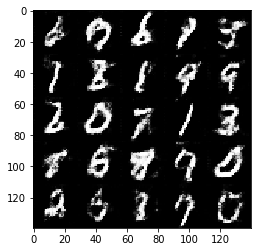

Epoch 1/2... Batch 410... Discriminator Loss: 1.2219... Generator Loss: 0.7724
Epoch 1/2... Batch 420... Discriminator Loss: 1.2486... Generator Loss: 0.7880
Epoch 1/2... Batch 430... Discriminator Loss: 1.3349... Generator Loss: 0.7398
Epoch 1/2... Batch 440... Discriminator Loss: 1.2851... Generator Loss: 0.8232
Epoch 1/2... Batch 450... Discriminator Loss: 1.2629... Generator Loss: 0.6840
Epoch 1/2... Batch 460... Discriminator Loss: 1.4073... Generator Loss: 0.7165


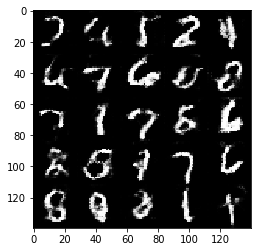

Epoch 2/2... Batch 10... Discriminator Loss: 1.3406... Generator Loss: 0.7880
Epoch 2/2... Batch 20... Discriminator Loss: 1.2970... Generator Loss: 0.7371
Epoch 2/2... Batch 30... Discriminator Loss: 1.4687... Generator Loss: 0.6976
Epoch 2/2... Batch 40... Discriminator Loss: 1.4472... Generator Loss: 0.7299
Epoch 2/2... Batch 50... Discriminator Loss: 1.2752... Generator Loss: 0.7751
Epoch 2/2... Batch 60... Discriminator Loss: 1.3166... Generator Loss: 0.7744
Epoch 2/2... Batch 70... Discriminator Loss: 1.3143... Generator Loss: 0.7659
Epoch 2/2... Batch 80... Discriminator Loss: 1.2510... Generator Loss: 0.8590
Epoch 2/2... Batch 90... Discriminator Loss: 1.3898... Generator Loss: 0.6122
Epoch 2/2... Batch 100... Discriminator Loss: 1.1250... Generator Loss: 0.8916


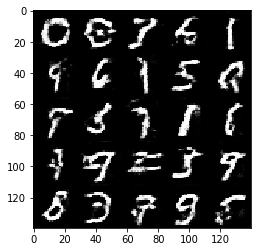

Epoch 2/2... Batch 110... Discriminator Loss: 1.1192... Generator Loss: 0.8976
Epoch 2/2... Batch 120... Discriminator Loss: 1.2783... Generator Loss: 0.7955
Epoch 2/2... Batch 130... Discriminator Loss: 1.4448... Generator Loss: 0.8289
Epoch 2/2... Batch 140... Discriminator Loss: 1.3647... Generator Loss: 0.8104
Epoch 2/2... Batch 150... Discriminator Loss: 1.2939... Generator Loss: 0.6612
Epoch 2/2... Batch 160... Discriminator Loss: 1.4298... Generator Loss: 0.7428
Epoch 2/2... Batch 170... Discriminator Loss: 1.3186... Generator Loss: 0.6954
Epoch 2/2... Batch 180... Discriminator Loss: 1.3534... Generator Loss: 0.7637
Epoch 2/2... Batch 190... Discriminator Loss: 1.1940... Generator Loss: 0.8538
Epoch 2/2... Batch 200... Discriminator Loss: 1.2913... Generator Loss: 0.7375


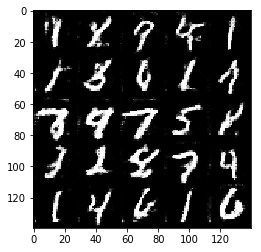

Epoch 2/2... Batch 210... Discriminator Loss: 1.2050... Generator Loss: 0.9041
Epoch 2/2... Batch 220... Discriminator Loss: 0.9872... Generator Loss: 1.0291
Epoch 2/2... Batch 230... Discriminator Loss: 1.3922... Generator Loss: 0.6645
Epoch 2/2... Batch 240... Discriminator Loss: 1.3267... Generator Loss: 0.7223
Epoch 2/2... Batch 250... Discriminator Loss: 1.2118... Generator Loss: 0.7232
Epoch 2/2... Batch 260... Discriminator Loss: 1.2819... Generator Loss: 0.7928
Epoch 2/2... Batch 270... Discriminator Loss: 1.0956... Generator Loss: 0.9708
Epoch 2/2... Batch 280... Discriminator Loss: 1.2575... Generator Loss: 0.6795
Epoch 2/2... Batch 290... Discriminator Loss: 1.1298... Generator Loss: 1.0742
Epoch 2/2... Batch 300... Discriminator Loss: 1.2333... Generator Loss: 1.0324


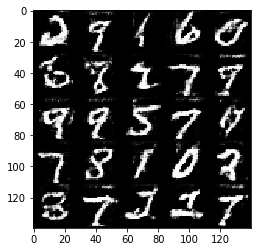

Epoch 2/2... Batch 310... Discriminator Loss: 1.1910... Generator Loss: 0.9131
Epoch 2/2... Batch 320... Discriminator Loss: 1.2048... Generator Loss: 0.8516
Epoch 2/2... Batch 330... Discriminator Loss: 1.2563... Generator Loss: 0.7763
Epoch 2/2... Batch 340... Discriminator Loss: 1.3585... Generator Loss: 0.8819
Epoch 2/2... Batch 350... Discriminator Loss: 1.2782... Generator Loss: 0.7457
Epoch 2/2... Batch 360... Discriminator Loss: 1.3266... Generator Loss: 0.6720
Epoch 2/2... Batch 370... Discriminator Loss: 1.2282... Generator Loss: 1.0387
Epoch 2/2... Batch 380... Discriminator Loss: 1.1708... Generator Loss: 0.9431
Epoch 2/2... Batch 390... Discriminator Loss: 1.3922... Generator Loss: 0.7160
Epoch 2/2... Batch 400... Discriminator Loss: 1.1541... Generator Loss: 0.7593


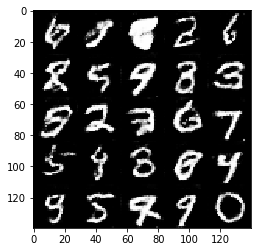

Epoch 2/2... Batch 410... Discriminator Loss: 1.0651... Generator Loss: 0.9509
Epoch 2/2... Batch 420... Discriminator Loss: 1.5449... Generator Loss: 1.1227
Epoch 2/2... Batch 430... Discriminator Loss: 1.3692... Generator Loss: 0.9339
Epoch 2/2... Batch 440... Discriminator Loss: 1.2656... Generator Loss: 0.7559
Epoch 2/2... Batch 450... Discriminator Loss: 0.9896... Generator Loss: 1.0948
Epoch 2/2... Batch 460... Discriminator Loss: 1.2125... Generator Loss: 0.8046


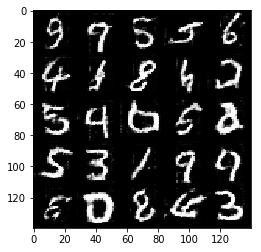

In [12]:
batch_size = 128
z_dim = 70
learning_rate = 0.001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Batch 10... Discriminator Loss: 0.2361... Generator Loss: 3.2767
Epoch 1/1... Batch 20... Discriminator Loss: 1.1319... Generator Loss: 0.6609
Epoch 1/1... Batch 30... Discriminator Loss: 1.7501... Generator Loss: 0.3800
Epoch 1/1... Batch 40... Discriminator Loss: 2.0335... Generator Loss: 0.3591
Epoch 1/1... Batch 50... Discriminator Loss: 1.9105... Generator Loss: 0.4143
Epoch 1/1... Batch 60... Discriminator Loss: 1.7587... Generator Loss: 0.5133
Epoch 1/1... Batch 70... Discriminator Loss: 1.6174... Generator Loss: 0.5580
Epoch 1/1... Batch 80... Discriminator Loss: 1.6504... Generator Loss: 0.5065
Epoch 1/1... Batch 90... Discriminator Loss: 1.5496... Generator Loss: 0.5841
Epoch 1/1... Batch 100... Discriminator Loss: 1.5812... Generator Loss: 0.5786


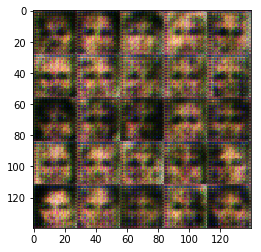

Epoch 1/1... Batch 110... Discriminator Loss: 1.4789... Generator Loss: 0.6148
Epoch 1/1... Batch 120... Discriminator Loss: 1.6394... Generator Loss: 0.5799
Epoch 1/1... Batch 130... Discriminator Loss: 1.5599... Generator Loss: 0.5849
Epoch 1/1... Batch 140... Discriminator Loss: 1.5850... Generator Loss: 0.6855
Epoch 1/1... Batch 150... Discriminator Loss: 1.5139... Generator Loss: 0.5897
Epoch 1/1... Batch 160... Discriminator Loss: 1.5783... Generator Loss: 0.5744
Epoch 1/1... Batch 170... Discriminator Loss: 1.5036... Generator Loss: 0.6176
Epoch 1/1... Batch 180... Discriminator Loss: 1.4737... Generator Loss: 0.6762
Epoch 1/1... Batch 190... Discriminator Loss: 1.4982... Generator Loss: 0.6594
Epoch 1/1... Batch 200... Discriminator Loss: 1.5069... Generator Loss: 0.6047


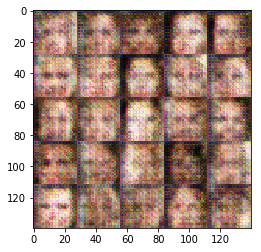

Epoch 1/1... Batch 210... Discriminator Loss: 1.6281... Generator Loss: 0.5843
Epoch 1/1... Batch 220... Discriminator Loss: 1.4433... Generator Loss: 0.7150
Epoch 1/1... Batch 230... Discriminator Loss: 1.4491... Generator Loss: 0.7340
Epoch 1/1... Batch 240... Discriminator Loss: 1.5370... Generator Loss: 0.5737
Epoch 1/1... Batch 250... Discriminator Loss: 1.5143... Generator Loss: 0.5875
Epoch 1/1... Batch 260... Discriminator Loss: 1.6043... Generator Loss: 0.5898
Epoch 1/1... Batch 270... Discriminator Loss: 1.5523... Generator Loss: 0.6266
Epoch 1/1... Batch 280... Discriminator Loss: 1.5726... Generator Loss: 0.6082
Epoch 1/1... Batch 290... Discriminator Loss: 1.4001... Generator Loss: 0.7359
Epoch 1/1... Batch 300... Discriminator Loss: 1.4737... Generator Loss: 0.7098


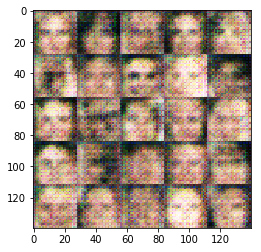

Epoch 1/1... Batch 310... Discriminator Loss: 1.5084... Generator Loss: 0.5765
Epoch 1/1... Batch 320... Discriminator Loss: 1.3900... Generator Loss: 0.7113
Epoch 1/1... Batch 330... Discriminator Loss: 1.4046... Generator Loss: 0.8361
Epoch 1/1... Batch 340... Discriminator Loss: 1.4696... Generator Loss: 0.7221
Epoch 1/1... Batch 350... Discriminator Loss: 1.4165... Generator Loss: 0.7048
Epoch 1/1... Batch 360... Discriminator Loss: 1.4348... Generator Loss: 0.7850
Epoch 1/1... Batch 370... Discriminator Loss: 1.4685... Generator Loss: 0.7105
Epoch 1/1... Batch 380... Discriminator Loss: 1.4743... Generator Loss: 0.6413
Epoch 1/1... Batch 390... Discriminator Loss: 1.4467... Generator Loss: 0.6510
Epoch 1/1... Batch 400... Discriminator Loss: 1.4153... Generator Loss: 0.7926


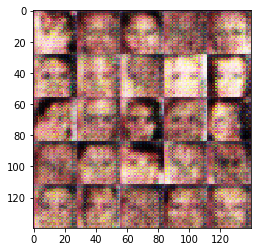

Epoch 1/1... Batch 410... Discriminator Loss: 1.3978... Generator Loss: 0.6987
Epoch 1/1... Batch 420... Discriminator Loss: 1.5261... Generator Loss: 0.6087
Epoch 1/1... Batch 430... Discriminator Loss: 1.4193... Generator Loss: 0.7381
Epoch 1/1... Batch 440... Discriminator Loss: 1.4908... Generator Loss: 0.5892
Epoch 1/1... Batch 450... Discriminator Loss: 1.3597... Generator Loss: 0.8196
Epoch 1/1... Batch 460... Discriminator Loss: 1.4541... Generator Loss: 0.6496
Epoch 1/1... Batch 470... Discriminator Loss: 1.4486... Generator Loss: 0.6284
Epoch 1/1... Batch 480... Discriminator Loss: 1.4104... Generator Loss: 0.7873
Epoch 1/1... Batch 490... Discriminator Loss: 1.4793... Generator Loss: 0.6730
Epoch 1/1... Batch 500... Discriminator Loss: 1.4429... Generator Loss: 0.7245


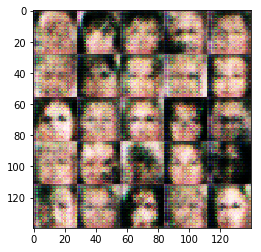

Epoch 1/1... Batch 510... Discriminator Loss: 1.4353... Generator Loss: 0.7868
Epoch 1/1... Batch 520... Discriminator Loss: 1.5417... Generator Loss: 0.7433
Epoch 1/1... Batch 530... Discriminator Loss: 1.4446... Generator Loss: 0.7610
Epoch 1/1... Batch 540... Discriminator Loss: 1.4495... Generator Loss: 0.6719
Epoch 1/1... Batch 550... Discriminator Loss: 1.4468... Generator Loss: 0.5990
Epoch 1/1... Batch 560... Discriminator Loss: 1.4162... Generator Loss: 0.7096
Epoch 1/1... Batch 570... Discriminator Loss: 1.4587... Generator Loss: 0.7471
Epoch 1/1... Batch 580... Discriminator Loss: 1.4353... Generator Loss: 0.6544
Epoch 1/1... Batch 590... Discriminator Loss: 1.4209... Generator Loss: 0.6727
Epoch 1/1... Batch 600... Discriminator Loss: 1.4400... Generator Loss: 0.6630


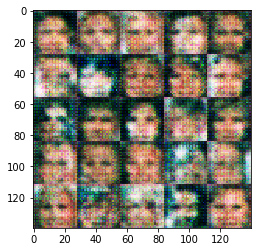

Epoch 1/1... Batch 610... Discriminator Loss: 1.4500... Generator Loss: 0.7351
Epoch 1/1... Batch 620... Discriminator Loss: 1.4221... Generator Loss: 0.7727
Epoch 1/1... Batch 630... Discriminator Loss: 1.4665... Generator Loss: 0.7143
Epoch 1/1... Batch 640... Discriminator Loss: 1.4167... Generator Loss: 0.7126
Epoch 1/1... Batch 650... Discriminator Loss: 1.4409... Generator Loss: 0.7361
Epoch 1/1... Batch 660... Discriminator Loss: 1.4415... Generator Loss: 0.8145
Epoch 1/1... Batch 670... Discriminator Loss: 1.3953... Generator Loss: 0.7455
Epoch 1/1... Batch 680... Discriminator Loss: 1.4141... Generator Loss: 0.7038
Epoch 1/1... Batch 690... Discriminator Loss: 1.4083... Generator Loss: 0.6523
Epoch 1/1... Batch 700... Discriminator Loss: 1.4311... Generator Loss: 0.6015


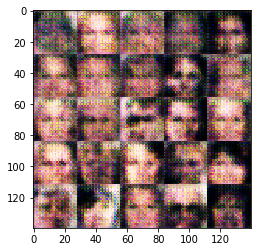

Epoch 1/1... Batch 710... Discriminator Loss: 1.4190... Generator Loss: 0.6640
Epoch 1/1... Batch 720... Discriminator Loss: 1.4894... Generator Loss: 0.6435
Epoch 1/1... Batch 730... Discriminator Loss: 1.4714... Generator Loss: 0.5721
Epoch 1/1... Batch 740... Discriminator Loss: 1.4121... Generator Loss: 0.7081
Epoch 1/1... Batch 750... Discriminator Loss: 1.4197... Generator Loss: 0.6212
Epoch 1/1... Batch 760... Discriminator Loss: 1.4638... Generator Loss: 0.6121
Epoch 1/1... Batch 770... Discriminator Loss: 1.5482... Generator Loss: 0.6486
Epoch 1/1... Batch 780... Discriminator Loss: 1.4617... Generator Loss: 0.7225
Epoch 1/1... Batch 790... Discriminator Loss: 1.4854... Generator Loss: 0.6578
Epoch 1/1... Batch 800... Discriminator Loss: 1.4339... Generator Loss: 0.6875


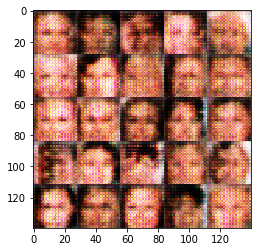

Epoch 1/1... Batch 810... Discriminator Loss: 1.4240... Generator Loss: 0.7293
Epoch 1/1... Batch 820... Discriminator Loss: 1.3907... Generator Loss: 0.7459
Epoch 1/1... Batch 830... Discriminator Loss: 1.4213... Generator Loss: 0.8216
Epoch 1/1... Batch 840... Discriminator Loss: 1.4135... Generator Loss: 0.7078
Epoch 1/1... Batch 850... Discriminator Loss: 1.4142... Generator Loss: 0.8010
Epoch 1/1... Batch 860... Discriminator Loss: 1.4514... Generator Loss: 0.6561
Epoch 1/1... Batch 870... Discriminator Loss: 1.4621... Generator Loss: 0.7420
Epoch 1/1... Batch 880... Discriminator Loss: 1.3814... Generator Loss: 0.7348
Epoch 1/1... Batch 890... Discriminator Loss: 1.4288... Generator Loss: 0.6371
Epoch 1/1... Batch 900... Discriminator Loss: 1.4493... Generator Loss: 0.6007


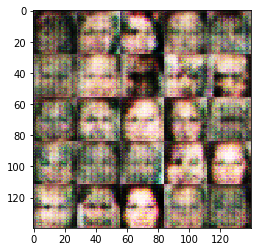

Epoch 1/1... Batch 910... Discriminator Loss: 1.3837... Generator Loss: 0.8160
Epoch 1/1... Batch 920... Discriminator Loss: 1.4378... Generator Loss: 0.7016
Epoch 1/1... Batch 930... Discriminator Loss: 1.4627... Generator Loss: 0.9589
Epoch 1/1... Batch 940... Discriminator Loss: 1.4266... Generator Loss: 0.8415
Epoch 1/1... Batch 950... Discriminator Loss: 1.4386... Generator Loss: 0.6576
Epoch 1/1... Batch 960... Discriminator Loss: 1.4150... Generator Loss: 0.7308
Epoch 1/1... Batch 970... Discriminator Loss: 1.4442... Generator Loss: 0.6168
Epoch 1/1... Batch 980... Discriminator Loss: 1.4271... Generator Loss: 0.8126
Epoch 1/1... Batch 990... Discriminator Loss: 1.3784... Generator Loss: 0.6978
Epoch 1/1... Batch 1000... Discriminator Loss: 1.4518... Generator Loss: 0.5842


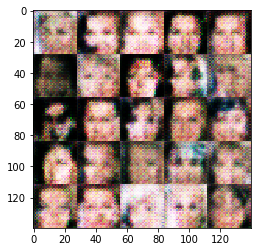

Epoch 1/1... Batch 1010... Discriminator Loss: 1.4315... Generator Loss: 0.8571
Epoch 1/1... Batch 1020... Discriminator Loss: 1.4250... Generator Loss: 0.7099
Epoch 1/1... Batch 1030... Discriminator Loss: 1.4195... Generator Loss: 0.8956
Epoch 1/1... Batch 1040... Discriminator Loss: 1.3954... Generator Loss: 0.6709
Epoch 1/1... Batch 1050... Discriminator Loss: 1.4223... Generator Loss: 0.8729
Epoch 1/1... Batch 1060... Discriminator Loss: 1.4404... Generator Loss: 0.6800
Epoch 1/1... Batch 1070... Discriminator Loss: 1.4197... Generator Loss: 0.7079
Epoch 1/1... Batch 1080... Discriminator Loss: 1.3986... Generator Loss: 0.7419
Epoch 1/1... Batch 1090... Discriminator Loss: 1.4388... Generator Loss: 0.7836
Epoch 1/1... Batch 1100... Discriminator Loss: 1.4182... Generator Loss: 0.8709


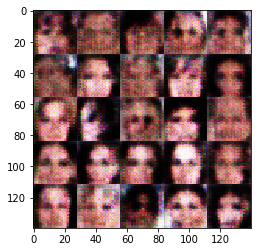

Epoch 1/1... Batch 1110... Discriminator Loss: 1.3966... Generator Loss: 0.6548
Epoch 1/1... Batch 1120... Discriminator Loss: 1.4488... Generator Loss: 0.6550
Epoch 1/1... Batch 1130... Discriminator Loss: 1.4381... Generator Loss: 0.6008
Epoch 1/1... Batch 1140... Discriminator Loss: 1.4042... Generator Loss: 0.6645
Epoch 1/1... Batch 1150... Discriminator Loss: 1.4169... Generator Loss: 0.6076
Epoch 1/1... Batch 1160... Discriminator Loss: 1.4480... Generator Loss: 0.5803
Epoch 1/1... Batch 1170... Discriminator Loss: 1.4715... Generator Loss: 0.5600
Epoch 1/1... Batch 1180... Discriminator Loss: 1.4198... Generator Loss: 0.6593
Epoch 1/1... Batch 1190... Discriminator Loss: 1.4099... Generator Loss: 0.7110
Epoch 1/1... Batch 1200... Discriminator Loss: 1.4265... Generator Loss: 0.7274


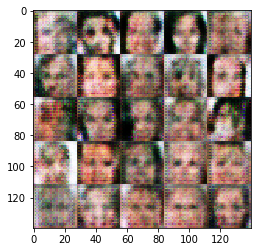

Epoch 1/1... Batch 1210... Discriminator Loss: 1.3956... Generator Loss: 0.6846
Epoch 1/1... Batch 1220... Discriminator Loss: 1.3937... Generator Loss: 0.6278
Epoch 1/1... Batch 1230... Discriminator Loss: 1.4042... Generator Loss: 0.7179
Epoch 1/1... Batch 1240... Discriminator Loss: 1.4357... Generator Loss: 0.6520
Epoch 1/1... Batch 1250... Discriminator Loss: 1.4050... Generator Loss: 0.6253
Epoch 1/1... Batch 1260... Discriminator Loss: 1.4078... Generator Loss: 0.7046
Epoch 1/1... Batch 1270... Discriminator Loss: 1.4220... Generator Loss: 0.6696
Epoch 1/1... Batch 1280... Discriminator Loss: 1.4390... Generator Loss: 0.8160
Epoch 1/1... Batch 1290... Discriminator Loss: 1.4001... Generator Loss: 0.7678
Epoch 1/1... Batch 1300... Discriminator Loss: 1.3892... Generator Loss: 0.7627


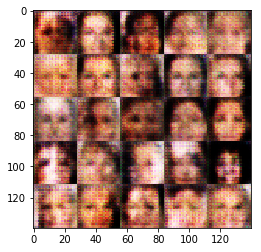

Epoch 1/1... Batch 1310... Discriminator Loss: 1.4114... Generator Loss: 0.7240
Epoch 1/1... Batch 1320... Discriminator Loss: 1.4453... Generator Loss: 0.6278
Epoch 1/1... Batch 1330... Discriminator Loss: 1.4718... Generator Loss: 0.7077
Epoch 1/1... Batch 1340... Discriminator Loss: 1.4436... Generator Loss: 0.6422
Epoch 1/1... Batch 1350... Discriminator Loss: 1.5155... Generator Loss: 0.5261
Epoch 1/1... Batch 1360... Discriminator Loss: 1.4051... Generator Loss: 0.7568
Epoch 1/1... Batch 1370... Discriminator Loss: 1.4162... Generator Loss: 0.6832
Epoch 1/1... Batch 1380... Discriminator Loss: 1.3675... Generator Loss: 0.7381
Epoch 1/1... Batch 1390... Discriminator Loss: 1.4004... Generator Loss: 0.7350
Epoch 1/1... Batch 1400... Discriminator Loss: 1.3824... Generator Loss: 0.7582


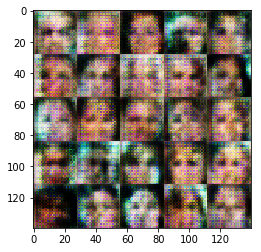

Epoch 1/1... Batch 1410... Discriminator Loss: 1.4035... Generator Loss: 0.7708
Epoch 1/1... Batch 1420... Discriminator Loss: 1.3831... Generator Loss: 0.6892
Epoch 1/1... Batch 1430... Discriminator Loss: 1.4103... Generator Loss: 0.8426
Epoch 1/1... Batch 1440... Discriminator Loss: 1.4257... Generator Loss: 0.8397
Epoch 1/1... Batch 1450... Discriminator Loss: 1.4310... Generator Loss: 0.6153
Epoch 1/1... Batch 1460... Discriminator Loss: 1.3938... Generator Loss: 0.7061
Epoch 1/1... Batch 1470... Discriminator Loss: 1.4008... Generator Loss: 0.7001
Epoch 1/1... Batch 1480... Discriminator Loss: 1.4540... Generator Loss: 0.9100
Epoch 1/1... Batch 1490... Discriminator Loss: 1.4450... Generator Loss: 0.5980
Epoch 1/1... Batch 1500... Discriminator Loss: 1.4284... Generator Loss: 0.8298


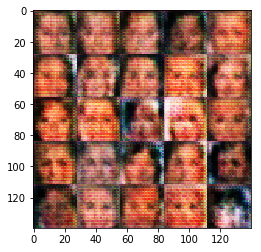

Epoch 1/1... Batch 1510... Discriminator Loss: 1.3846... Generator Loss: 0.7485
Epoch 1/1... Batch 1520... Discriminator Loss: 1.4158... Generator Loss: 0.7710
Epoch 1/1... Batch 1530... Discriminator Loss: 1.4169... Generator Loss: 0.6960
Epoch 1/1... Batch 1540... Discriminator Loss: 1.4547... Generator Loss: 0.8732
Epoch 1/1... Batch 1550... Discriminator Loss: 1.4059... Generator Loss: 0.7136
Epoch 1/1... Batch 1560... Discriminator Loss: 1.3918... Generator Loss: 0.7462
Epoch 1/1... Batch 1570... Discriminator Loss: 1.4244... Generator Loss: 0.8337
Epoch 1/1... Batch 1580... Discriminator Loss: 1.4147... Generator Loss: 0.8101
Epoch 1/1... Batch 1590... Discriminator Loss: 1.4148... Generator Loss: 0.6986
Epoch 1/1... Batch 1600... Discriminator Loss: 1.3977... Generator Loss: 0.8352


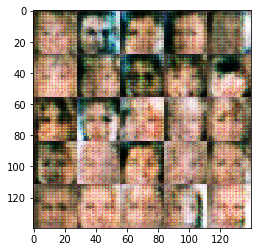

Epoch 1/1... Batch 1610... Discriminator Loss: 1.4080... Generator Loss: 0.7650
Epoch 1/1... Batch 1620... Discriminator Loss: 1.4060... Generator Loss: 0.8359
Epoch 1/1... Batch 1630... Discriminator Loss: 1.4035... Generator Loss: 0.7073
Epoch 1/1... Batch 1640... Discriminator Loss: 1.3990... Generator Loss: 0.7648
Epoch 1/1... Batch 1650... Discriminator Loss: 1.4022... Generator Loss: 0.7516
Epoch 1/1... Batch 1660... Discriminator Loss: 1.3769... Generator Loss: 0.7926
Epoch 1/1... Batch 1670... Discriminator Loss: 1.4071... Generator Loss: 0.8126
Epoch 1/1... Batch 1680... Discriminator Loss: 1.4392... Generator Loss: 0.8597
Epoch 1/1... Batch 1690... Discriminator Loss: 1.3922... Generator Loss: 0.7377
Epoch 1/1... Batch 1700... Discriminator Loss: 1.4513... Generator Loss: 0.7685


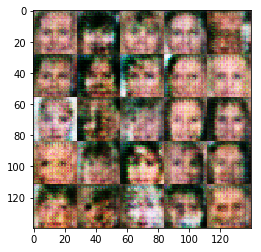

Epoch 1/1... Batch 1710... Discriminator Loss: 1.4390... Generator Loss: 0.6385
Epoch 1/1... Batch 1720... Discriminator Loss: 1.4073... Generator Loss: 0.7853
Epoch 1/1... Batch 1730... Discriminator Loss: 1.4065... Generator Loss: 0.6477
Epoch 1/1... Batch 1740... Discriminator Loss: 1.4292... Generator Loss: 0.9018
Epoch 1/1... Batch 1750... Discriminator Loss: 1.4313... Generator Loss: 0.7886
Epoch 1/1... Batch 1760... Discriminator Loss: 1.4043... Generator Loss: 0.7625
Epoch 1/1... Batch 1770... Discriminator Loss: 1.3836... Generator Loss: 0.7159
Epoch 1/1... Batch 1780... Discriminator Loss: 1.4467... Generator Loss: 0.5798
Epoch 1/1... Batch 1790... Discriminator Loss: 1.4261... Generator Loss: 0.7069
Epoch 1/1... Batch 1800... Discriminator Loss: 1.4410... Generator Loss: 0.7294


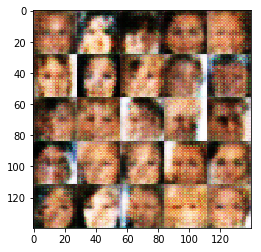

Epoch 1/1... Batch 1810... Discriminator Loss: 1.4972... Generator Loss: 0.5119
Epoch 1/1... Batch 1820... Discriminator Loss: 1.3922... Generator Loss: 0.7353
Epoch 1/1... Batch 1830... Discriminator Loss: 1.4192... Generator Loss: 0.7493
Epoch 1/1... Batch 1840... Discriminator Loss: 1.4289... Generator Loss: 0.7135
Epoch 1/1... Batch 1850... Discriminator Loss: 1.3687... Generator Loss: 0.6653
Epoch 1/1... Batch 1860... Discriminator Loss: 1.3838... Generator Loss: 0.7470
Epoch 1/1... Batch 1870... Discriminator Loss: 1.2915... Generator Loss: 0.5979
Epoch 1/1... Batch 1880... Discriminator Loss: 1.4293... Generator Loss: 0.9970
Epoch 1/1... Batch 1890... Discriminator Loss: 1.1625... Generator Loss: 0.7162
Epoch 1/1... Batch 1900... Discriminator Loss: 2.0367... Generator Loss: 1.9435


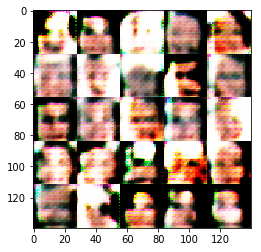

Epoch 1/1... Batch 1910... Discriminator Loss: 1.4121... Generator Loss: 0.6834
Epoch 1/1... Batch 1920... Discriminator Loss: 1.4636... Generator Loss: 0.7361
Epoch 1/1... Batch 1930... Discriminator Loss: 1.3830... Generator Loss: 0.7262
Epoch 1/1... Batch 1940... Discriminator Loss: 1.4152... Generator Loss: 0.6411
Epoch 1/1... Batch 1950... Discriminator Loss: 1.3548... Generator Loss: 0.8044
Epoch 1/1... Batch 1960... Discriminator Loss: 1.4018... Generator Loss: 0.7642
Epoch 1/1... Batch 1970... Discriminator Loss: 1.4048... Generator Loss: 0.7710
Epoch 1/1... Batch 1980... Discriminator Loss: 1.4414... Generator Loss: 0.6562
Epoch 1/1... Batch 1990... Discriminator Loss: 1.4423... Generator Loss: 0.7137
Epoch 1/1... Batch 2000... Discriminator Loss: 1.3804... Generator Loss: 0.7659


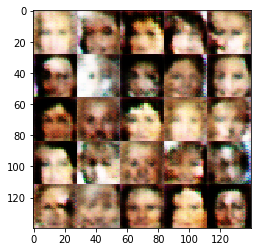

Epoch 1/1... Batch 2010... Discriminator Loss: 1.4322... Generator Loss: 0.7912
Epoch 1/1... Batch 2020... Discriminator Loss: 1.4295... Generator Loss: 0.5955
Epoch 1/1... Batch 2030... Discriminator Loss: 1.3926... Generator Loss: 0.7549
Epoch 1/1... Batch 2040... Discriminator Loss: 1.4103... Generator Loss: 0.7926
Epoch 1/1... Batch 2050... Discriminator Loss: 1.3961... Generator Loss: 0.6029
Epoch 1/1... Batch 2060... Discriminator Loss: 1.4570... Generator Loss: 0.5917
Epoch 1/1... Batch 2070... Discriminator Loss: 1.3987... Generator Loss: 0.8220
Epoch 1/1... Batch 2080... Discriminator Loss: 1.3877... Generator Loss: 0.6794
Epoch 1/1... Batch 2090... Discriminator Loss: 1.4010... Generator Loss: 0.7597
Epoch 1/1... Batch 2100... Discriminator Loss: 1.4319... Generator Loss: 0.8338


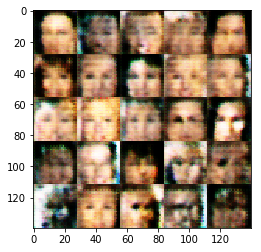

Epoch 1/1... Batch 2110... Discriminator Loss: 1.3719... Generator Loss: 0.7282
Epoch 1/1... Batch 2120... Discriminator Loss: 1.3888... Generator Loss: 0.6876
Epoch 1/1... Batch 2130... Discriminator Loss: 1.3964... Generator Loss: 0.7715
Epoch 1/1... Batch 2140... Discriminator Loss: 1.3810... Generator Loss: 0.7048
Epoch 1/1... Batch 2150... Discriminator Loss: 1.4131... Generator Loss: 0.6147
Epoch 1/1... Batch 2160... Discriminator Loss: 1.3959... Generator Loss: 0.8589
Epoch 1/1... Batch 2170... Discriminator Loss: 1.4069... Generator Loss: 0.7104
Epoch 1/1... Batch 2180... Discriminator Loss: 1.4009... Generator Loss: 0.6534
Epoch 1/1... Batch 2190... Discriminator Loss: 1.3799... Generator Loss: 0.7623
Epoch 1/1... Batch 2200... Discriminator Loss: 1.4202... Generator Loss: 0.8475


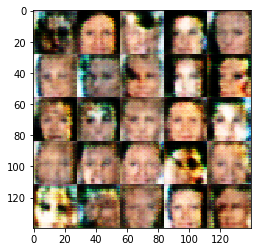

Epoch 1/1... Batch 2210... Discriminator Loss: 1.4133... Generator Loss: 0.7598
Epoch 1/1... Batch 2220... Discriminator Loss: 1.4169... Generator Loss: 0.7353
Epoch 1/1... Batch 2230... Discriminator Loss: 1.3810... Generator Loss: 0.7611
Epoch 1/1... Batch 2240... Discriminator Loss: 1.3848... Generator Loss: 0.7697
Epoch 1/1... Batch 2250... Discriminator Loss: 1.3974... Generator Loss: 0.8976
Epoch 1/1... Batch 2260... Discriminator Loss: 1.4040... Generator Loss: 0.8825
Epoch 1/1... Batch 2270... Discriminator Loss: 1.4011... Generator Loss: 0.7132
Epoch 1/1... Batch 2280... Discriminator Loss: 1.4220... Generator Loss: 0.6149
Epoch 1/1... Batch 2290... Discriminator Loss: 1.4171... Generator Loss: 0.6060
Epoch 1/1... Batch 2300... Discriminator Loss: 1.4312... Generator Loss: 0.7484


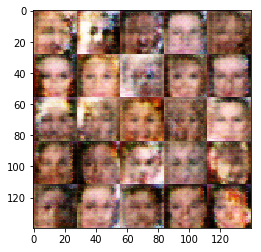

Epoch 1/1... Batch 2310... Discriminator Loss: 1.3810... Generator Loss: 0.7819
Epoch 1/1... Batch 2320... Discriminator Loss: 1.4013... Generator Loss: 0.6649
Epoch 1/1... Batch 2330... Discriminator Loss: 1.3922... Generator Loss: 0.7139
Epoch 1/1... Batch 2340... Discriminator Loss: 1.3898... Generator Loss: 0.7817
Epoch 1/1... Batch 2350... Discriminator Loss: 1.4280... Generator Loss: 0.5870
Epoch 1/1... Batch 2360... Discriminator Loss: 1.3859... Generator Loss: 0.6499
Epoch 1/1... Batch 2370... Discriminator Loss: 1.4062... Generator Loss: 0.7347
Epoch 1/1... Batch 2380... Discriminator Loss: 1.3968... Generator Loss: 0.7253
Epoch 1/1... Batch 2390... Discriminator Loss: 1.4066... Generator Loss: 0.7924
Epoch 1/1... Batch 2400... Discriminator Loss: 1.3940... Generator Loss: 0.8318


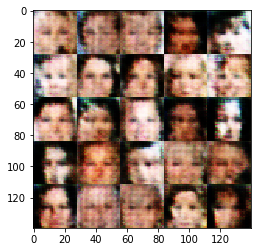

Epoch 1/1... Batch 2410... Discriminator Loss: 1.4291... Generator Loss: 0.6571
Epoch 1/1... Batch 2420... Discriminator Loss: 1.4016... Generator Loss: 0.7237
Epoch 1/1... Batch 2430... Discriminator Loss: 1.3944... Generator Loss: 0.7318
Epoch 1/1... Batch 2440... Discriminator Loss: 1.3930... Generator Loss: 0.8601
Epoch 1/1... Batch 2450... Discriminator Loss: 1.3912... Generator Loss: 0.7025
Epoch 1/1... Batch 2460... Discriminator Loss: 1.3968... Generator Loss: 0.7382
Epoch 1/1... Batch 2470... Discriminator Loss: 1.3840... Generator Loss: 0.7161
Epoch 1/1... Batch 2480... Discriminator Loss: 1.3951... Generator Loss: 0.6830
Epoch 1/1... Batch 2490... Discriminator Loss: 1.3906... Generator Loss: 0.6987
Epoch 1/1... Batch 2500... Discriminator Loss: 1.3650... Generator Loss: 0.7784


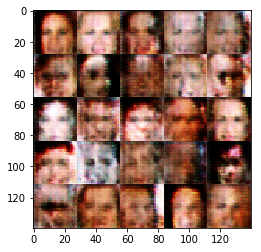

Epoch 1/1... Batch 2510... Discriminator Loss: 1.3831... Generator Loss: 0.7765
Epoch 1/1... Batch 2520... Discriminator Loss: 1.3971... Generator Loss: 0.6688
Epoch 1/1... Batch 2530... Discriminator Loss: 1.4207... Generator Loss: 0.6219
Epoch 1/1... Batch 2540... Discriminator Loss: 1.3826... Generator Loss: 0.7237
Epoch 1/1... Batch 2550... Discriminator Loss: 1.4189... Generator Loss: 0.5752
Epoch 1/1... Batch 2560... Discriminator Loss: 1.4177... Generator Loss: 0.7784
Epoch 1/1... Batch 2570... Discriminator Loss: 1.4346... Generator Loss: 0.7216
Epoch 1/1... Batch 2580... Discriminator Loss: 1.4213... Generator Loss: 0.6476
Epoch 1/1... Batch 2590... Discriminator Loss: 1.4498... Generator Loss: 0.9153
Epoch 1/1... Batch 2600... Discriminator Loss: 1.3814... Generator Loss: 0.6999


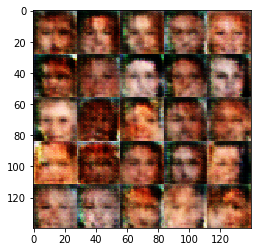

Epoch 1/1... Batch 2610... Discriminator Loss: 1.3929... Generator Loss: 0.7422
Epoch 1/1... Batch 2620... Discriminator Loss: 1.4177... Generator Loss: 0.5972
Epoch 1/1... Batch 2630... Discriminator Loss: 1.3890... Generator Loss: 0.6849
Epoch 1/1... Batch 2640... Discriminator Loss: 1.3982... Generator Loss: 0.6714
Epoch 1/1... Batch 2650... Discriminator Loss: 1.4232... Generator Loss: 0.6260
Epoch 1/1... Batch 2660... Discriminator Loss: 1.4067... Generator Loss: 0.7267
Epoch 1/1... Batch 2670... Discriminator Loss: 1.4106... Generator Loss: 0.6874
Epoch 1/1... Batch 2680... Discriminator Loss: 1.3937... Generator Loss: 0.7766
Epoch 1/1... Batch 2690... Discriminator Loss: 1.3846... Generator Loss: 0.6948
Epoch 1/1... Batch 2700... Discriminator Loss: 1.4010... Generator Loss: 0.7419


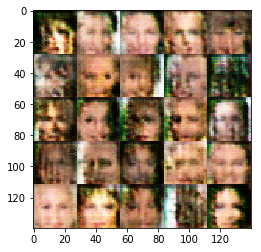

Epoch 1/1... Batch 2710... Discriminator Loss: 1.4031... Generator Loss: 0.7208
Epoch 1/1... Batch 2720... Discriminator Loss: 1.4067... Generator Loss: 0.7297
Epoch 1/1... Batch 2730... Discriminator Loss: 1.3911... Generator Loss: 0.6791
Epoch 1/1... Batch 2740... Discriminator Loss: 1.3953... Generator Loss: 0.6625
Epoch 1/1... Batch 2750... Discriminator Loss: 1.3872... Generator Loss: 0.7576
Epoch 1/1... Batch 2760... Discriminator Loss: 1.3991... Generator Loss: 0.6656
Epoch 1/1... Batch 2770... Discriminator Loss: 1.3884... Generator Loss: 0.7386
Epoch 1/1... Batch 2780... Discriminator Loss: 1.3853... Generator Loss: 0.6836
Epoch 1/1... Batch 2790... Discriminator Loss: 1.3868... Generator Loss: 0.8164
Epoch 1/1... Batch 2800... Discriminator Loss: 1.4042... Generator Loss: 0.7063


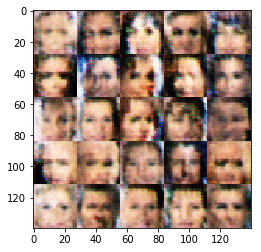

Epoch 1/1... Batch 2810... Discriminator Loss: 1.3990... Generator Loss: 0.7321
Epoch 1/1... Batch 2820... Discriminator Loss: 1.3864... Generator Loss: 0.7470
Epoch 1/1... Batch 2830... Discriminator Loss: 1.3941... Generator Loss: 0.7825
Epoch 1/1... Batch 2840... Discriminator Loss: 1.3809... Generator Loss: 0.7374
Epoch 1/1... Batch 2850... Discriminator Loss: 1.4415... Generator Loss: 0.9545
Epoch 1/1... Batch 2860... Discriminator Loss: 1.4116... Generator Loss: 0.8020
Epoch 1/1... Batch 2870... Discriminator Loss: 1.4015... Generator Loss: 0.7568
Epoch 1/1... Batch 2880... Discriminator Loss: 1.3849... Generator Loss: 0.8081
Epoch 1/1... Batch 2890... Discriminator Loss: 1.4699... Generator Loss: 0.6133
Epoch 1/1... Batch 2900... Discriminator Loss: 1.4027... Generator Loss: 0.7539


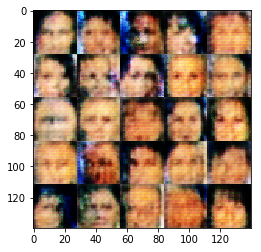

Epoch 1/1... Batch 2910... Discriminator Loss: 1.4014... Generator Loss: 0.6471
Epoch 1/1... Batch 2920... Discriminator Loss: 1.4271... Generator Loss: 0.9476
Epoch 1/1... Batch 2930... Discriminator Loss: 1.3841... Generator Loss: 0.7194
Epoch 1/1... Batch 2940... Discriminator Loss: 1.4156... Generator Loss: 0.7162
Epoch 1/1... Batch 2950... Discriminator Loss: 1.3824... Generator Loss: 0.7897
Epoch 1/1... Batch 2960... Discriminator Loss: 1.3986... Generator Loss: 0.8062
Epoch 1/1... Batch 2970... Discriminator Loss: 1.4066... Generator Loss: 0.6175
Epoch 1/1... Batch 2980... Discriminator Loss: 1.4021... Generator Loss: 0.6569
Epoch 1/1... Batch 2990... Discriminator Loss: 1.3785... Generator Loss: 0.7804
Epoch 1/1... Batch 3000... Discriminator Loss: 1.4063... Generator Loss: 0.6098


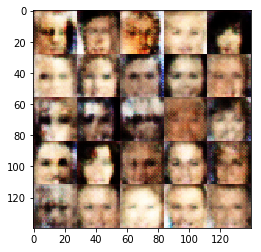

Epoch 1/1... Batch 3010... Discriminator Loss: 1.4376... Generator Loss: 0.7196
Epoch 1/1... Batch 3020... Discriminator Loss: 1.4115... Generator Loss: 0.6046
Epoch 1/1... Batch 3030... Discriminator Loss: 1.3934... Generator Loss: 0.7695
Epoch 1/1... Batch 3040... Discriminator Loss: 1.3853... Generator Loss: 0.7093
Epoch 1/1... Batch 3050... Discriminator Loss: 1.4181... Generator Loss: 0.5904
Epoch 1/1... Batch 3060... Discriminator Loss: 1.4297... Generator Loss: 0.5657
Epoch 1/1... Batch 3070... Discriminator Loss: 1.4021... Generator Loss: 0.7072
Epoch 1/1... Batch 3080... Discriminator Loss: 1.3907... Generator Loss: 0.6882
Epoch 1/1... Batch 3090... Discriminator Loss: 1.3889... Generator Loss: 0.7388
Epoch 1/1... Batch 3100... Discriminator Loss: 1.4252... Generator Loss: 0.8404


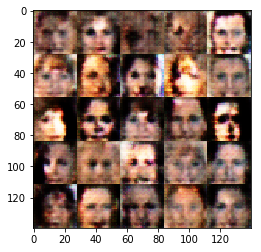

Epoch 1/1... Batch 3110... Discriminator Loss: 1.3944... Generator Loss: 0.7884
Epoch 1/1... Batch 3120... Discriminator Loss: 1.3685... Generator Loss: 0.7592
Epoch 1/1... Batch 3130... Discriminator Loss: 1.4101... Generator Loss: 0.7741
Epoch 1/1... Batch 3140... Discriminator Loss: 1.4077... Generator Loss: 0.7046
Epoch 1/1... Batch 3150... Discriminator Loss: 1.3915... Generator Loss: 0.7890
Epoch 1/1... Batch 3160... Discriminator Loss: 1.3893... Generator Loss: 0.7947


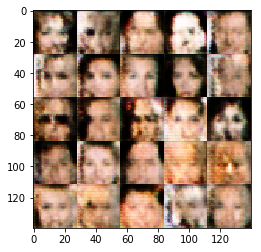

In [15]:
batch_size = 64
z_dim = 70
learning_rate = 0.001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.